In [ ]:
!nvidia-smi

Sat Jun 25 13:05:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%cd /content/drive/MyDrive/program

/content/drive/MyDrive/program


In [ ]:
# !git clone https://github.com/ezaaputra/indonlu.git

In [ ]:
# %cd /content/drive/MyDrive/program/indonlu

In [ ]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 30.1 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=313a06f2c621e390d2680dd335574c7f1959156be99beb205eb927f1227865f7
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 19.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 35.9 MB/s 
     |████████████████████████████████| 101 kB 13.8 MB/s 
     |████████████████████████████████| 6.6 MB 53.1 MB/s 
     |████████████████████████████████| 596 kB 56.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.1

In [ ]:
%pwd

'/content/drive/MyDrive/program'

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

# NLP
import nltk
nltk.download('punkt')
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

#Model IndoBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df_path = '/content/drive/MyDrive/dataset/dataset.csv'
dataset = pd.read_csv(df_path)
dataset.rename(columns={"0": "cuitan"}, inplace=True)
dataset

,cuitan
0,Komisi VIII Dukung Kebijakan Menag Soal Aturan...
1,Komisi VIII Dukung Kebijakan Menag Soal Aturan...
2,Komisi VIII Dukung Kebijakan Menag Soal Aturan...
3,Komisi VIII Dukung Kebijakan Menag Soal Aturan...
4,Komisi VIII Dukung Kebijakan Menag Soal Aturan...
...,...
415,💠PENGERAS SUARA 💠 Negara2 Islam mengatur pengg...
416,@ruhulmaani Silahkan di baca transkrip di bawa...
417,"Pak Dekan, bisa sampaikan ilmu Bapak ke geromb..."
418,Pengaruh Pernyataan Aturan Pengeras Suara di M...


In [ ]:
label = pd.read_excel("/content/drive/MyDrive/dataset/label.xlsx", sheet_name="Sheet1")
label

,category
0,positive
1,positive
2,positive
3,positive
4,positive
...,...
415,positive
416,neutral
417,positive
418,neutral


In [ ]:
dataset = pd.concat([dataset, label], axis=1)
dataset

,cuitan,category
0,Komisi VIII Dukung Kebijakan Menag Soal Aturan...,positive
1,Komisi VIII Dukung Kebijakan Menag Soal Aturan...,positive
2,Komisi VIII Dukung Kebijakan Menag Soal Aturan...,positive
3,Komisi VIII Dukung Kebijakan Menag Soal Aturan...,positive
4,Komisi VIII Dukung Kebijakan Menag Soal Aturan...,positive
...,...,...
415,💠PENGERAS SUARA 💠 Negara2 Islam mengatur pengg...,positive
416,@ruhulmaani Silahkan di baca transkrip di bawa...,neutral
417,"Pak Dekan, bisa sampaikan ilmu Bapak ke geromb...",positive
418,Pengaruh Pernyataan Aturan Pengeras Suara di M...,neutral


In [ ]:
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

def repeatcharClean(text): 
  for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long 
      text = text.replace(char,character[i])
      charac_long -= 1
  return text

In [ ]:
def clean_review(text):
  text = text.lower()
  text = re.sub(r'\n', ' ', text)
  text = emoji.demojize(text)
  text = re.sub(':[A-Za-z_-]+:', ' ', text)
  text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)
  text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text)
  text = re.sub(r"@[^\s]+[\s]?", ' ', text)
  text = re.sub(r'#(\S+)', r'\1', text)
  text = re.sub('[^a-zA-Z2".!?]+',' ',text)
  # text = re.sub('[^a-zA-Z0-9]+',' ',text)
  text = repeatcharClean(text)
  text = re.sub('[ ]+',' ',text)
  return text

In [ ]:
def preprocess_v1(df):
  df_pp = df.copy()
  df_pp.cuitan = df_pp.cuitan.map(clean_review)

  df_pp.cuitan.replace('', np.nan, inplace=True)
  df_pp.cuitan.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['cuitan'], inplace=True)
  return df_pp

In [ ]:
df = dataset
df_v1 = preprocess_v1(df)

In [ ]:
print(df_v1.to_markdown())

|     | cuitan                                                                                                                                                                                                                                                                                   | category   |
|----:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------|
|   0 | komisi vi dukung kebijakan menag soal aturan pengeras suara masjid                                                                                                                                                                                                                       | positive   |
|   1 | komisi vi dukung kebijakan menag soal aturan pengeras suara masjid semangat memb

In [ ]:
df_v1.to_csv('/content/sample_data/preprocessing1.csv')

In [ ]:
stopword_path = 'https://docs.google.com/spreadsheets/d/1u3dXlVORlpwYnXoQCkCKDSqiyYh-HQYF8qWS1XSvNdU/gviz/tq?tqx=out:csv&sheet=Sheet1'
additional_stop = [] #['ya', 'deh', 'dia']
default_stop = pd.read_csv(stopword_path, names=['stopwords'])
default_stop = default_stop.stopwords.to_list()
list_stopwords = []
list_stopwords = default_stop + additional_stop

kamus singkatan

In [ ]:
sheet_id = "1PjT2IoIYTXPBz946mEnUTcxlLuLUFsC6iU4ih1HVVEc"
sheet_name = 'kamus'
tidak_baku_path = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
tidak_baku = pd.read_csv(tidak_baku_path) 

normalize_word_dict = {}
for index, row in tidak_baku.iterrows():
    if row[0] not in normalize_word_dict:
        normalize_word_dict[row[0]] = row[1]

In [ ]:
def normalize_review(text):
  list_text = word_tokenize(text)
  list_text = [normalize_word_dict[term] if term in normalize_word_dict else term for term in list_text]
  list_text = [word for word in list_text if word not in list_stopwords]
  text = " ".join(list_text)
  return text

In [ ]:
def preprocess_v2(df):
  df_pp = df.copy()
  df_pp.cuitan = df_pp.cuitan.map(normalize_review)

  df_pp.cuitan.replace('', np.nan, inplace=True)
  df_pp.cuitan.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['cuitan'], inplace=True)
  return df_pp

In [ ]:
df_v2  = preprocess_v2(df_v1)

In [ ]:
df_v2.cuitan[0]

'komisi dukung kebijakan menag aturan pengeras suara masjid'

In [ ]:
print(df_v2.to_markdown())

|     | cuitan                                                                                                                                                                                                                                                            | category   |
|----:|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------|
|   0 | komisi dukung kebijakan menag aturan pengeras suara masjid                                                                                                                                                                                                        | positive   |
|   1 | komisi dukung kebijakan menag aturan pengeras suara masjid semangat membangun nusantara                                                              

In [ ]:
df_v2['cuitan'] = df_v2['cuitan'].str.replace('.','', regex=True)
df_v2['cuitan'] = df_v2['cuitan'].str.replace('2','', regex=True)
df_v2['cuitan'] = df_v2['cuitan'].str.replace('?','', regex=True)
df_v2['cuitan'] = df_v2['cuitan'].str.replace('"','', regex=True)
df_v2['cuitan'] = df_v2['cuitan'].str.replace('!','', regex=True)
df_v2['cuitan'] = df_v2['cuitan'].str.replace(r'\s+', ' ', regex=True)

In [ ]:
df_v2['cuitan'].str.findall(r'[?]').str.len().sum()

0

In [ ]:
print(df_v2.to_markdown())

|     | cuitan                                                                                                                                                                                                                                                 | category   |
|----:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------|
|   0 | komisi dukung kebijakan menag aturan pengeras suara masjid                                                                                                                                                                                             | positive   |
|   1 | komisi dukung kebijakan menag aturan pengeras suara masjid semangat membangun nusantara                                                                                               

cek jumlah tweet

In [ ]:
df_v2.shape

(420, 2)

In [ ]:
df_v2

,cuitan,category
0,komisi dukung kebijakan menag aturan pengeras ...,positive
1,komisi dukung kebijakan menag aturan pengeras ...,positive
2,komisi dukung kebijakan menag aturan pengeras ...,positive
3,komisi dukung kebijakan menag aturan pengeras ...,positive
4,komisi dukung kebijakan menag aturan pengeras ...,positive
...,...,...
415,pengeras suara negara negara islam mengatur pe...,positive
416,silahkan baca transkrip salah ya salah bela ma...,neutral
417,dekan ilmu gerombolan penolak aturan toa dekan...,positive
418,pengaruh pernyataan aturan pengeras suara masj...,neutral


In [ ]:
df_v2 = df_v2.drop_duplicates(['cuitan'])
df_v2.shape

(315, 2)

In [ ]:
df_v2.shape

(315, 2)

In [ ]:
df_v2

,cuitan,category
0,komisi dukung kebijakan menag aturan pengeras ...,positive
1,komisi dukung kebijakan menag aturan pengeras ...,positive
9,aturan pengeras suara masjid mushola pedoman s...,positive
12,ormas islam cimahi sepakat dukung surat edaran...,positive
13,komisi dukung kebijakan menag aturan pengeras ...,positive
...,...,...
395,menag bandingkan toa masjid anjing menggonggon...,neutral
397,menteri agama menerbitkan aturan pengeras suar...,neutral
398,perombakan kabinet menteri agama menerbitkan a...,neutral
399,beradab berilmu menteri agama menerbitkan atur...,negative


In [ ]:
def make_corpus(column):
    
    corpus_list = []

    for text in column:
        cleaned_list = text.split(' ')
        corpus_list.extend(cleaned_list)     
        
    # transform list of words into 1 body of text
    corpus = ' '.join(corpus_list)
    corpus = re.sub('[ ]+',' ',corpus) # replace double whitespace with one
        
    return corpus

In [ ]:
# Takes a while
corpus = make_corpus(df_v2.cuitan)

In [ ]:
corpus

"komisi dukung kebijakan menag aturan pengeras suara masjid komisi dukung kebijakan menag aturan pengeras suara masjid semangat membangun nusantara aturan pengeras suara masjid mushola pedoman surat edaran menag nomor ormas islam cimahi sepakat dukung surat edaran menag terkait aturan pengeras suara masjid mandalika nusantara jaya komisi dukung kebijakan menag aturan pengeras suara masjid nusantara jaya abadi komisi dukung kebijakan menag aturan pengeras suara masjid yptyx semangat membangun nusantara komisi dukung kebijakan menag aturan pengeras suara masjid semangat membangun nusantara y nusantara jaya abadi komisi dukung kebijakan menag aturan pengeras suara masjid meme aturan pengeras suara masjid polekmik jaringan akar rumput pmii saltiga dukung menag tegakkan aturan pengeras suara masjid patuhi disiplin prokes menteri agama yaqut cholil qoumas mengeluarkan surat edaran terkait aturan pengeras suara masjid musala spekulasi bergulir masyarakat indonesia lantas majelis ulama indones

In [ ]:
corpus

"komisi dukung kebijakan menag aturan pengeras suara masjid komisi dukung kebijakan menag aturan pengeras suara masjid semangat membangun nusantara aturan pengeras suara masjid mushola pedoman surat edaran menag nomor ormas islam cimahi sepakat dukung surat edaran menag terkait aturan pengeras suara masjid mandalika nusantara jaya komisi dukung kebijakan menag aturan pengeras suara masjid nusantara jaya abadi komisi dukung kebijakan menag aturan pengeras suara masjid yptyx semangat membangun nusantara komisi dukung kebijakan menag aturan pengeras suara masjid semangat membangun nusantara y nusantara jaya abadi komisi dukung kebijakan menag aturan pengeras suara masjid meme aturan pengeras suara masjid polekmik jaringan akar rumput pmii saltiga dukung menag tegakkan aturan pengeras suara masjid patuhi disiplin prokes menteri agama yaqut cholil qoumas mengeluarkan surat edaran terkait aturan pengeras suara masjid musala spekulasi bergulir masyarakat indonesia lantas majelis ulama indones

In [ ]:
corpus_set = set(corpus.split(' '))

print(f'Count of unique words in corpus: {len(corpus_set)}')

Count of unique words in corpus: 1059


lihat frekuensi kata

In [ ]:
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples 

    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})
    
    return df

In [ ]:
corpus_freq = word_freq(corpus, top=20)

In [ ]:
corpus_freq

,word,freq
0,suara,363
1,masjid,355
2,pengeras,341
3,aturan,338
4,menag,112
5,toa,75
6,yaqut,54
7,edaran,53
8,surat,52
9,agama,50


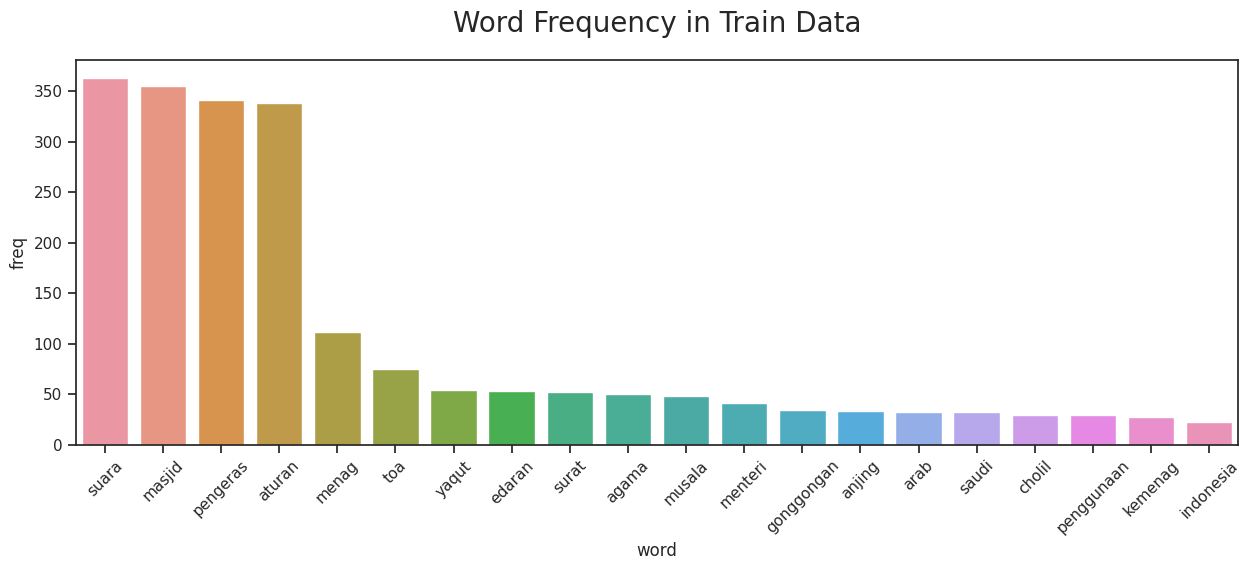

In [ ]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))

sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)

plt.show()

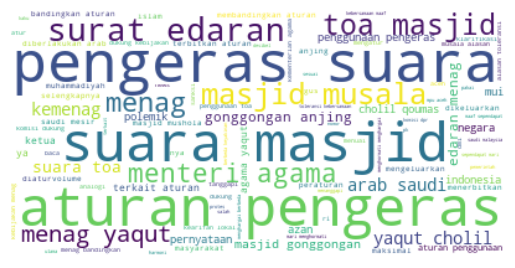

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
df_v2['category'].value_counts()

neutral     130
positive    104
negative     81
Name: category, dtype: int64

In [ ]:
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%', 
           startangle = angle, pctdistance=0.8, explode = explode, 
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')  
    plt.tight_layout()

In [ ]:
# Plot arguments
sizes = df.category.value_counts()
labels = ['cuitan positif', 'cuitan negatif', 'cuitan netral']
colors = ['lightgreen', 'lightskyblue', 'lightcoral']
explode = (0,0,0)

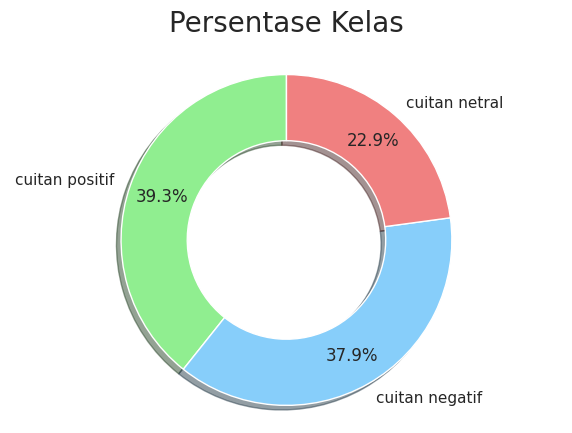

In [ ]:
# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Persentase Kelas')

plt.show()

In [ ]:
train_set, val_set = train_test_split(df_v2, test_size=0.3, stratify=df_v2.category, random_state=1)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.category, random_state=1)

In [ ]:
print(f'Train shape: {train_set.shape}')
print(f'Val shape: {val_set.shape}')
print(f'Test shape: {test_set.shape}')

Train shape: (220, 2)
Val shape: (63, 2)
Test shape: (32, 2)


In [ ]:
train_set.to_csv('/content/drive/MyDrive/data_split/train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('/content/drive/MyDrive/data_split/val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('/content/drive/MyDrive/data_split/test_set.tsv', sep='\t', header=None, index=False)

In [ ]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [ ]:
set_seed(27)

#load model

In [ ]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
count_param(model)

124443651

In [ ]:
train_dataset_path = '/content/drive/MyDrive/data_split/train_set.tsv'
valid_dataset_path = '/content/drive/MyDrive/data_split/val_set.tsv'
test_dataset_path = '/content/drive/MyDrive/data_split/test_set.tsv'

In [ ]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)  
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i) #word to index
print(i2w) #index to word

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [ ]:
text = 'pemuda mendukung aturan toa masjid'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: pemuda pancasila mendukung aturan toa masjid | Label : positive (43.912%)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [ ]:
# Train
n_epochs = 20
history = defaultdict(list)
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Hitung skor train metrics
        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    
    # save train acc for learning curve
    history['train_acc'].append(metrics['ACC'])

    # Evaluate di validation set
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
        # Hitung total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Hitung skor evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    # save validation acc for learning curve
    history['val_acc'].append(metrics['ACC'])

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 1) TRAIN LOSS:1.2123 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


(Epoch 1) TRAIN LOSS:1.2123 ACC:0.35 F1:0.30 REC:0.40 PRE:0.35 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:1.1024 ACC:0.35 F1:0.23 REC:0.36 PRE:0.31: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


(Epoch 1) VALID LOSS:1.1024 ACC:0.35 F1:0.23 REC:0.36 PRE:0.31


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 2) TRAIN LOSS:1.0803 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


(Epoch 2) TRAIN LOSS:1.0803 ACC:0.43 F1:0.37 REC:0.41 PRE:0.43 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.9818 ACC:0.62 F1:0.44 REC:0.48 PRE:0.41:  50%|█████     | 1/2 [00:00<00:00,  1.52it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Preci

(Epoch 2) VALID LOSS:1.0531 ACC:0.52 F1:0.40 REC:0.48 PRE:0.35


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 3) TRAIN LOSS:1.0462 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


(Epoch 3) TRAIN LOSS:1.0462 ACC:0.46 F1:0.34 REC:0.40 PRE:0.65 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.9594 ACC:0.53 F1:0.34 REC:0.38 PRE:0.37:  50%|█████     | 1/2 [00:00<00:00,  1.45it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Preci

(Epoch 3) VALID LOSS:1.0457 ACC:0.43 F1:0.28 REC:0.36 PRE:0.31


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 4) TRAIN LOSS:1.0206 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(Epoch 4) TRAIN LOSS:1.0206 ACC:0.45 F1:0.30 REC:0.38 PRE:0.33 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.9479 ACC:0.53 F1:0.34 REC:0.38 PRE:0.37:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Preci

(Epoch 4) VALID LOSS:1.0283 ACC:0.48 F1:0.35 REC:0.41 PRE:0.36


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 5) TRAIN LOSS:1.0007 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


(Epoch 5) TRAIN LOSS:1.0007 ACC:0.52 F1:0.43 REC:0.46 PRE:0.70 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:1.0031 ACC:0.56 F1:0.42 REC:0.49 PRE:0.38: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


(Epoch 5) VALID LOSS:1.0031 ACC:0.56 F1:0.42 REC:0.49 PRE:0.38


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 6) TRAIN LOSS:0.9720 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


(Epoch 6) TRAIN LOSS:0.9720 ACC:0.56 F1:0.50 REC:0.51 PRE:0.63 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.9828 ACC:0.54 F1:0.46 REC:0.49 PRE:0.52: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


(Epoch 6) VALID LOSS:0.9828 ACC:0.54 F1:0.46 REC:0.49 PRE:0.52


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 7) TRAIN LOSS:0.9447 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


(Epoch 7) TRAIN LOSS:0.9447 ACC:0.61 F1:0.56 REC:0.56 PRE:0.69 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.9627 ACC:0.56 F1:0.47 REC:0.51 PRE:0.58: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


(Epoch 7) VALID LOSS:0.9627 ACC:0.56 F1:0.47 REC:0.51 PRE:0.58


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 8) TRAIN LOSS:0.9122 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


(Epoch 8) TRAIN LOSS:0.9122 ACC:0.64 F1:0.60 REC:0.60 PRE:0.68 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.9404 ACC:0.59 F1:0.52 REC:0.54 PRE:0.63: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


(Epoch 8) VALID LOSS:0.9404 ACC:0.59 F1:0.52 REC:0.54 PRE:0.63


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 9) TRAIN LOSS:0.8491 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


(Epoch 9) TRAIN LOSS:0.8491 ACC:0.71 F1:0.67 REC:0.67 PRE:0.78 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.9132 ACC:0.62 F1:0.59 REC:0.59 PRE:0.67: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


(Epoch 9) VALID LOSS:0.9132 ACC:0.62 F1:0.59 REC:0.59 PRE:0.67


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 10) TRAIN LOSS:0.8311 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


(Epoch 10) TRAIN LOSS:0.8311 ACC:0.72 F1:0.70 REC:0.69 PRE:0.75 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.8800 ACC:0.67 F1:0.65 REC:0.64 PRE:0.68: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


(Epoch 10) VALID LOSS:0.8800 ACC:0.67 F1:0.65 REC:0.64 PRE:0.68


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 11) TRAIN LOSS:0.7718 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


(Epoch 11) TRAIN LOSS:0.7718 ACC:0.76 F1:0.75 REC:0.74 PRE:0.78 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.8600 ACC:0.68 F1:0.66 REC:0.65 PRE:0.73: 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


(Epoch 11) VALID LOSS:0.8600 ACC:0.68 F1:0.66 REC:0.65 PRE:0.73


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 12) TRAIN LOSS:0.7153 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


(Epoch 12) TRAIN LOSS:0.7153 ACC:0.78 F1:0.77 REC:0.75 PRE:0.82 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.8363 ACC:0.67 F1:0.64 REC:0.64 PRE:0.67: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


(Epoch 12) VALID LOSS:0.8363 ACC:0.67 F1:0.64 REC:0.64 PRE:0.67


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 13) TRAIN LOSS:0.6890 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


(Epoch 13) TRAIN LOSS:0.6890 ACC:0.79 F1:0.78 REC:0.77 PRE:0.81 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.8128 ACC:0.73 F1:0.71 REC:0.71 PRE:0.72: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


(Epoch 13) VALID LOSS:0.8128 ACC:0.73 F1:0.71 REC:0.71 PRE:0.72


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 14) TRAIN LOSS:0.6125 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


(Epoch 14) TRAIN LOSS:0.6125 ACC:0.86 F1:0.86 REC:0.85 PRE:0.87 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.7893 ACC:0.71 F1:0.69 REC:0.69 PRE:0.71: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


(Epoch 14) VALID LOSS:0.7893 ACC:0.71 F1:0.69 REC:0.69 PRE:0.71


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 15) TRAIN LOSS:0.5707 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


(Epoch 15) TRAIN LOSS:0.5707 ACC:0.88 F1:0.88 REC:0.87 PRE:0.88 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.7684 ACC:0.70 F1:0.68 REC:0.67 PRE:0.69: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


(Epoch 15) VALID LOSS:0.7684 ACC:0.70 F1:0.68 REC:0.67 PRE:0.69


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 16) TRAIN LOSS:0.5236 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


(Epoch 16) TRAIN LOSS:0.5236 ACC:0.89 F1:0.88 REC:0.87 PRE:0.90 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.7403 ACC:0.75 F1:0.73 REC:0.73 PRE:0.74: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


(Epoch 16) VALID LOSS:0.7403 ACC:0.75 F1:0.73 REC:0.73 PRE:0.74


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 17) TRAIN LOSS:0.4730 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


(Epoch 17) TRAIN LOSS:0.4730 ACC:0.93 F1:0.93 REC:0.92 PRE:0.93 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.7247 ACC:0.76 F1:0.75 REC:0.75 PRE:0.76: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


(Epoch 17) VALID LOSS:0.7247 ACC:0.76 F1:0.75 REC:0.75 PRE:0.76


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 18) TRAIN LOSS:0.4247 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


(Epoch 18) TRAIN LOSS:0.4247 ACC:0.92 F1:0.92 REC:0.92 PRE:0.93 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.7283 ACC:0.75 F1:0.73 REC:0.73 PRE:0.74: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


(Epoch 18) VALID LOSS:0.7283 ACC:0.75 F1:0.73 REC:0.73 PRE:0.74


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 19) TRAIN LOSS:0.3929 LR:0.00000300: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


(Epoch 19) TRAIN LOSS:0.3929 ACC:0.94 F1:0.94 REC:0.93 PRE:0.94 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.7112 ACC:0.75 F1:0.74 REC:0.73 PRE:0.74: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


(Epoch 19) VALID LOSS:0.7112 ACC:0.75 F1:0.74 REC:0.73 PRE:0.74


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
(Epoch 20) TRAIN LOSS:0.3451 LR:0.00000300: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


(Epoch 20) TRAIN LOSS:0.3451 ACC:0.95 F1:0.95 REC:0.95 PRE:0.96 LR:0.00000300


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
VALID LOSS:0.6935 ACC:0.76 F1:0.75 REC:0.74 PRE:0.76: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

(Epoch 20) VALID LOSS:0.6935 ACC:0.76 F1:0.75 REC:0.74 PRE:0.76


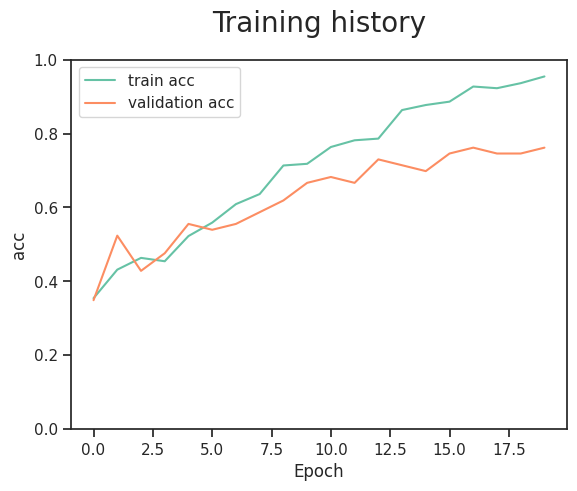

In [ ]:
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# Simpan Hasil Prediksi Validation Set
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['cuitan', 'category'])
val_df['pred'] = list_hyp
val_df.head()
val_df.to_csv('/content/drive/MyDrive/data_evaluasi/val_result.csv', index=False)

In [ ]:
# Prediksi test set
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
pred, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


In [ ]:
# Simpan prediksi test set
test_df = pd.read_csv(test_dataset_path, sep='\t', names=['cuitan', 'category'])
test_df['pred'] = pred
test_df.head()
test_df.to_csv('/content/drive/MyDrive/data_evaluasi/test_result.csv', index=False)

In [ ]:
val_real = val_df.category
val_pred = val_df.pred

test_real = test_df.category
test_pred = test_df.pred

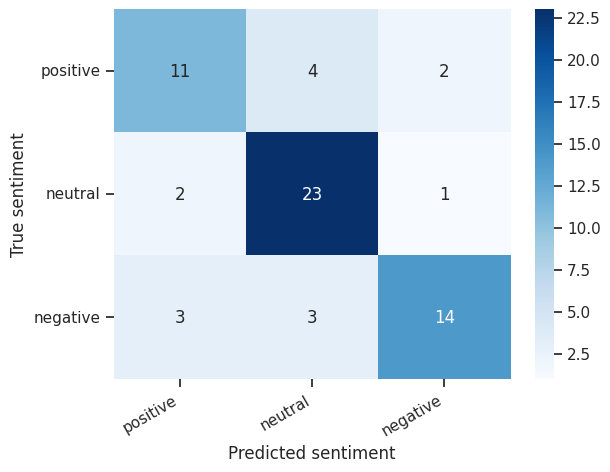

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  
cm = confusion_matrix(val_real, val_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(val_real, val_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.69      0.65      0.67        17
     neutral       0.77      0.88      0.82        26
    negative       0.82      0.70      0.76        20

    accuracy                           0.76        63
   macro avg       0.76      0.74      0.75        63
weighted avg       0.76      0.76      0.76        63



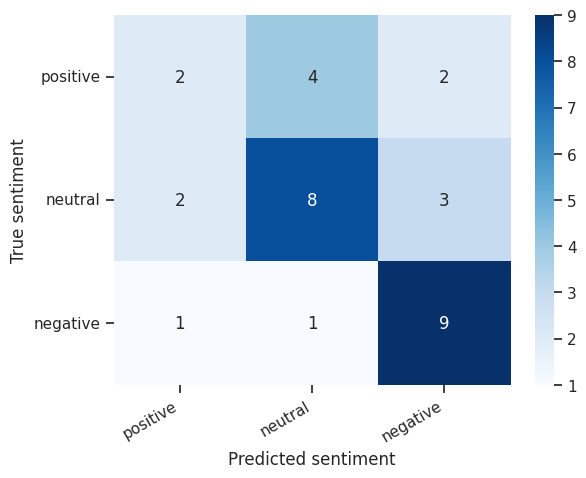

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  
cm = confusion_matrix(test_real, test_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(test_real, test_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.40      0.25      0.31         8
     neutral       0.62      0.62      0.62        13
    negative       0.64      0.82      0.72        11

    accuracy                           0.59        32
   macro avg       0.55      0.56      0.55        32
weighted avg       0.57      0.59      0.57        32

